In [1]:
%config IPCompleter.use_jedi = False
import numpyro
numpyro.enable_x64()
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

import jax
from jax import numpy as jnp
from jax import random
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS, Predictive
from numpyro.contrib.funsor import config_enumerate

from jax.scipy.special import digamma, polygamma, logit, expit, erf

import numpy as np
from numpy.random import default_rng
import pandas as pd
import seaborn as sns

https://stla.github.io/stlapblog/posts/RoundedData.html <-- this blog post is helpful
https://www.zora.uzh.ch/id/eprint/171988/1/ZORA_NL_171988.pdf <-- this paper could be helpful

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

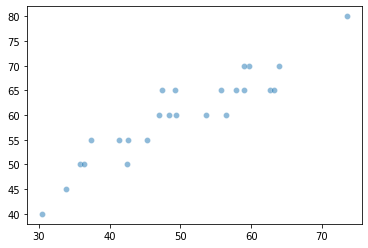

In [19]:
# first data that is all rounded to five

n_obs = 25
rg = default_rng(12345)

def round_to_one(x):
    return jnp.round(x,0)

def round_to_five(x):
    return jnp.round(x/5,0)*5

def round_to_twenty(x):
    return jnp.round(x/20,0)*20

# x_true = rg.beta(.25*10,.75*10,n_obs)*100
x_true = rg.normal(50,10, n_obs)
y_true = 20 + .8*x_true + rg.normal(0,3,n_obs)
y_obs = round_to_five(y_true)


sns.scatterplot(x_true, y_obs, alpha=.5)

In [20]:
# def spread_vec(x, step_size):
#     base_steps = x.shape[0]
#     x_split = jnp.split(x, base_steps)
#     pad = jnp.zeros(step_size-1) + jnp.exp(-30)
#     probs = jnp.stack([jnp.concatenate((i,pad)) for i in x_split]).flatten()
    
#     return probs[:-(step_size-1)]/jnp.sum(probs[:(step_size-1)]) # normalize probabilities
# def spread_vec(x, step_size):
#     base_steps = x.shape[0]
#     x_split = jnp.split(x, base_steps)
#     pad = jnp.zeros(step_size-1) + jnp.exp(-30)
#     probs = jnp.stack([jnp.concatenate((i,pad)) for i in x_split]).flatten()
#     if step_size!=1:
#         probs = probs[:base_steps*step_size-pad.shape[0]]
#     return probs/jnp.sum(probs) # normalize probabilities

def spread_vec(x, step_size):
    base_steps = x.shape[0]
    x_tall = x.reshape(-1,1) # reshape
    pad = jnp.zeros([x.shape[0], step_size-1]) + jnp.exp(-60) # make zeros
    probs = jnp.concatenate((x_tall, pad), axis=-1).flatten() # concatenate and flatten
    probs = probs[:base_steps*step_size - (step_size-1)]    # index
    
    return probs/jnp.sum(probs) # normalize probabilities


def logit_normal_cdf(mu, sigma, x):
    inner = (logit(x) - mu)/ jnp.sqrt(2*jnp.power(sigma, 2))
    return .5 * (1 + erf(inner))


# def beta_approx_cdf(a, b, x):
#     # normal approximation, not great
#     # mode K(a, b) = ((a – 1)/(ab – 1))1/a = mode beta(α, β) = (α – 1)/(α + β – 2).
#     mu_est = digamma(a) - digamma(b)
#     sigma_est = jnp.sqrt(polygamma(1, a) + polygamma(1, b))
    
#     return logit_normal_cdf(mu_est, sigma_est, x)

def beta_approx_params(a, b):
    # normal approximation, not great
    # mode K(a, b) = ((a – 1)/(ab – 1))1/a = mode beta(α, β) = (α – 1)/(α + β – 2).
    mu_est = digamma(a) - digamma(b)
    sigma_est = jnp.sqrt(polygamma(1, a) + polygamma(1, b))
    
    return mu_est, sigma_est


def beta_approx_cdf_norm(a, b, x):
    # normal approximation, not great
    # mode K(a, b) = ((a – 1)/(ab – 1))1/a = mode beta(α, β) = (α – 1)/(α + β – 2).
    mu = a/(a+b)
    sigma = jnp.sqrt((a*b)/(jnp.power(a+b,2)*(a+b+1.)))
    
    return dist.Normal(mu, sigma).cdf(x)

# def make_cuts(start, stop, step_size):
#     cut_points = np.arange(start, stop, step_size)+step_size/2
#     upper_pts = jnp.clip(cut_points + step_size/2 , a_max=100, a_min=0)
#     lower_pts = jnp.clip(cut_points - step_size/2, a_max=100, a_min=0)
#     return upper_pts, lower_pts

def make_cuts(start, stop, step_size):
    cut_points = np.arange(start, stop, step_size)
    upper_pts = jnp.clip(cut_points + step_size/2 , a_max=100, a_min=0)
    lower_pts = jnp.clip(cut_points - step_size/2, a_max=100, a_min=0)
    return lower_pts, upper_pts


def categorical_probs(a, b, step_size, max_size=100):

    upper_pts, lower_pts = make_cuts(0,100,step_size)
    
#     prob_dist = beta_approx_cdf(a,b) # replace with Kumaraswamy approx.
    probs = beta_approx_cdf(a,b,upper_pts/100.) - beta_approx_cdf(a,b,lower_pts/100.)
    return probs

def categorical_probs_spread(a, b, step_size, max_size=100):
    x = categorical_probs(a, b, step_size, max_size)
    
    return spread_vec(x, step_size)

In [21]:
def cat_probs_norm(mu, sigma, step_size, max_size=101):

    lower_pts, upper_pts = make_cuts(0,101,step_size)
    
    prob_dist = dist.Normal(mu, sigma)
    probs = prob_dist.cdf(upper_pts) - prob_dist.cdf(lower_pts) + jnp.exp(-30) # make sure it's non-zero
    
    return probs


vec_cat_probs = jax.vmap(cat_probs_norm, in_axes = (0, None, None))
vec_spread_vec = jax.vmap(spread_vec, in_axes = (0, None))

def vec_cat_probs_spread(mu, sigma, step_size, max_size=101):

    return vec_spread_vec(vec_cat_probs(mu, sigma, step_size), step_size)


def rounding_model(X, y_obs=None, step_size=5):
    alpha = numpyro.sample("alpha", dist.Normal(0,100))
    beta = numpyro.sample("beta", dist.Normal(0,100))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(50))
    
    yhat = alpha + beta*X
    
    with numpyro.plate("data", X.shape[0]):

        x_true_cp = vec_cat_probs(yhat, sigma, step_size)
        numpyro.sample("x", dist.Categorical(x_true_cp), obs=y_obs/step_size)
        
# the above works but (likely) not if you try to make it a latent thing. 

In [22]:
mcmc_test = MCMC(NUTS(rounding_model, target_accept_prob=.80), 1000, 1000, num_chains=1)
mcmc_test.run(random.PRNGKey(0), x_true, y_obs, 5)   

sample: 100%|██████████| 2000/2000 [00:06<00:00, 329.82it/s, 31 steps of size 1.23e-01. acc. prob=0.95]


In [23]:
mcmc_test.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     22.53      3.45     22.26     16.87     27.68    320.57      1.00
      beta      0.75      0.07      0.75      0.64      0.85    321.85      1.00
     sigma      3.30      0.63      3.21      2.24      4.25    361.76      1.00

Number of divergences: 0


## Mixture model

Works when we assume underlying latent gaussian. Even works allowing rounding to 1, but it is slow.

In [27]:
def reshape_theta(theta, n_obs, n_steps, n_categories):
    theta_vec = jnp.reshape(theta, (-1, n_steps))
    theta_obj = theta_vec.repeat(n_obs, axis=-1)
    theta_obj = jnp.reshape(theta_obj.repeat(n_categories, axis=-1), (n_steps, n_obs, n_categories))
    
    return theta_obj


def rounding_mixture_model(X, y_obs=None):
    n_obs = X.shape[0]
    steps = jnp.array([1, 5, 10])    
    theta = numpyro.sample("theta", dist.Dirichlet(jnp.ones(len(steps))))

    alpha = numpyro.sample("alpha", dist.Normal(0,100))
    beta = numpyro.sample("beta", dist.Normal(0,100))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(50))
    
    yhat = alpha + beta*X
    
    theta_obj = reshape_theta(theta, n_obs, len(steps), 101)

    with numpyro.plate("data", X.shape[0]):
        
        x_true_cp_stack = jnp.stack([ vec_cat_probs_spread(yhat, sigma, step_size)  for step_size in steps])
#         x_true_cp = vec_cat_probs_spread(yhat, sigma, step_size)
        x_true_cp = jnp.exp(jax.scipy.special.logsumexp(jnp.log(x_true_cp_stack) + jnp.log(theta_obj), axis=-3))
        numpyro.sample("x", dist.Categorical(x_true_cp), obs=y_obs)

In [28]:
mcmc_test = MCMC(NUTS(rounding_mixture_model, target_accept_prob=.80), 1000, 1000, num_chains=1)
mcmc_test.run(random.PRNGKey(0), x_true, y_obs)   

sample: 100%|██████████| 2000/2000 [01:13<00:00, 27.15it/s, 31 steps of size 1.62e-01. acc. prob=0.91]


In [29]:
mcmc_test.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     22.89      3.51     22.85     17.36     28.94    267.16      1.00
      beta      0.74      0.07      0.74      0.62      0.85    279.43      1.00
     sigma      3.24      0.61      3.17      2.31      4.28    480.01      1.00
  theta[0]      0.05      0.04      0.03      0.00      0.11    852.21      1.00
  theta[1]      0.81      0.11      0.82      0.65      1.00    576.38      1.00
  theta[2]      0.15      0.11      0.13      0.00      0.30    549.11      1.00

Number of divergences: 0


# Where am I?

## What's working?

I can model a latent mixture of rounding policies when the latent variable is normal because i have a differentiable implementation of `dist.Normal().cdf()`. So I don't sample the latent, I just pass the `yhat` into a function that directly creates the categorical probabilities for the different rounding schemes.

I can also model data with a known rounding policy using the measurement error approach advocated by Gelman. In this case, I should be able to model this for any underlying distribution (Normal, Beta, etc.).

So if I know the rounding policy, can proceed. If I don't, can only get it to work if the latent underlying distribution is normal (and it's a bit slow with rounding to 1 of 100 is an option).

## What's not working

My original vision was a "composable" approach where I'd sample a latent "true" variable and then pass that into the rounding model to predict the observed values. The idea here was you could have any model you like for the "cognitve" part of the model and then compose that with whatever other factors you like for the "response" part of the model. This might not be something that's at all feasible, or I might just not be implementing it right (it's possible I have been using a "centered" parameterization and could do better with a "non-centered" parameterization, but it's unclear how to implement that change for anything but a normal distribution, which makes it sort of pointless). 


## numerically compute beta CDF?

The reason I can't adapt the approach that is working for the bayesian sampler work is that the underlying latent distribution is not a normal distribution but rather Beta. And the cdf of the beta is does not have its derivatives/gradients implemented in `jax`, so it can't be used directly. Theoretically, I should be able to compute an approximation to the cdf with numerical integration purly in jax.numpy functions, which would preserve gradients. It's easy enough to write the `numeric_beta_cdf()` function but it doesn't work when implemented inside a numpyro program.

# numerical estimation of normal cdf

To see if this idea works, going to try the numerical integration with the normal CDF. This way I have a test case that I know works with the analytic CDF with which to compare.

In [24]:
# can we do it replacing the analytic CDF with a numerical integration approximation?
def numeric_norm_cdf(mu, sigma, lower, upper, approx_steps=1000):
    
    x_region = jnp.linspace( lower, upper, approx_steps)
    return jnp.sum(jnp.exp(dist.Normal(mu, sigma).log_prob(x_region))*((lower-upper)/x_region.shape[0]), axis=-2)


def cat_probs_norm_num(mu, sigma, step_size, max_size=101):

    lower_pts, upper_pts = make_cuts(0,101,step_size)
    
    probs = numeric_norm_cdf(mu, sigma, lower_pts, upper_pts) + jnp.exp(-60)
    
    return probs


vec_cat_probs_num = jax.vmap(cat_probs_norm_num, in_axes = (0, None, None))
vec_spread_vec = jax.vmap(spread_vec, in_axes = (0, None))

def vec_cat_probs_spread(mu, sigma, step_size, max_size=101):

    return vec_spread_vec(vec_cat_probs(mu, sigma, step_size), step_size)


def rounding_model_num(X, y_obs=None, step_size=5):
    alpha = numpyro.sample("alpha", dist.Normal(0,10))
    beta = numpyro.sample("beta", dist.Normal(0,10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(20))
    
    yhat = alpha + beta*X
    
    with numpyro.plate("data", X.shape[0]):

        x_true_cp = vec_cat_probs_num(yhat, sigma, step_size)
        numpyro.sample("x", dist.Categorical(x_true_cp), obs=y_obs/step_size)
        
# the above works but (likely) not if you try to make it a latent thing. 

cat_probs_norm_num(0,1,5)

DeviceArray([-4.93817110e-01, -6.24736780e-03, -3.24893953e-14,
              8.75651076e-27,  8.75651076e-27,  8.75651076e-27,
              8.75651076e-27,  8.75651076e-27,  8.75651076e-27,
              8.75651076e-27,  8.75651076e-27,  8.75651076e-27,
              8.75651076e-27,  8.75651076e-27,  8.75651076e-27,
              8.75651076e-27,  8.75651076e-27,  8.75651076e-27,
              8.75651076e-27,  8.75651076e-27,  8.75651076e-27],            dtype=float64)

In [25]:
mcmc_test = MCMC(NUTS(rounding_model_num, target_accept_prob=.80), 1000, 1000, num_chains=1)
mcmc_test.run(random.PRNGKey(0), x_true, y_obs, 5)   

sample: 100%|██████████| 2000/2000 [01:49<00:00, 18.25it/s, 1 steps of size 1.49e-01. acc. prob=0.81] 


In [26]:
mcmc_test.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.78     10.06     -1.30    -18.72     15.04     97.75      1.00
      beta     -6.64     10.22     -7.97    -22.62     11.45     21.00      1.07
     sigma     10.64      9.06      8.56      0.08     22.40    122.88      1.00

Number of divergences: 817


## __verdict:__ Doesn't work!

## Doomed attempts to get numerical estiamted beta CDF working

In [544]:
def spread_vec(x, step_size):
    base_steps = x.shape[0]
    x_tall = x.reshape(-1,1)
    pad = jnp.zeros([x.shape[0], step_size-1]) + jnp.exp(-30)
    probs = jnp.concatenate((x_tall, pad), axis=-1).flatten()
    probs = probs[:base_steps*step_size - (step_size-1)]    
    
    return probs/jnp.sum(probs) # normalize probabilities

spread_vec(cat_probs_norm(20,3,1),1)[80]
# jnp.exp(-60)
# x = jnp.arange(0,21).reshape(-1,1)
# pad = jnp.zeros([21,4])
# z = jnp.concatenate((x,pad), axis=-1).flatten()
# z.shape
# spread_vec(cat_probs_norm(10,10,10),10).shape
# make_cuts(0,101,1)[0].shape
# jnp.split(jnp.arange(0,10), 10)
# jnp.zeros(1-1) + jnp.exp(-30)
# jnp.arange(0,10)[:10]

DeviceArray(8.756511e-27, dtype=float32)

In [609]:
## implementing my own betacdf with jnp.trapz()

x_region = jnp.linspace(0+jnp.exp(-50),.4, 1000)

# %timeit midpoint_p = jax.scipy.special.logsumexp(dist.Beta(1,10).log_prob(x_region)*(.4/50))
%timeit midpoint_p2 = jnp.sum(jnp.exp(dist.Beta(10,2).log_prob(x_region))*(.4/1000))
%timeit trapz_p = jnp.trapz( jnp.exp(dist.Beta(10,2).log_prob(x_region)), dx=.4/1000)
%timeit exact_p = dist.Beta(10,2).cdf(.4)


4.15 ms ± 68.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.03 ms ± 64 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
911 µs ± 27.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [681]:
# # print(jax.scipy.special.logsumexp(dist.Beta(2,10).log_prob(x_region)+jnp.log(.4/50)))
# print(jnp.sum(jnp.exp(dist.Beta(10,2).log_prob(x_region))*(.4/50)))
# print(jnp.trapz( jnp.exp(dist.Beta(10,2).log_prob(x_region)), dx=.4/50))
# print(dist.Beta(10,2).cdf(.4))

# print(jnp.sum(jnp.exp(dist.Beta(10,2).log_prob(x_region))*(.4/1000)))
# print(jnp.trapz( jnp.exp(dist.Beta(10,2).log_prob(x_region)), dx=.4/1000))
# print(dist.Beta(10,2).cdf(.4))

# def numeric_beta_cdf(a, b, x, approx_steps=1000):
#     base = jnp.zeros(x.shape) + jnp.exp(-50)
    
#     x_region = jnp.linspace( 0+jnp.exp(-50), x, approx_steps)

#     return jnp.sum(jnp.exp(dist.Beta(a,b).log_prob(x_region))*(x/x_region.shape[0]))

# vec_numeric_beta_cdf = jax.vmap(numeric_beta_cdf, (None, None, 0, None))


# print(vec_numeric_beta_cdf(10, 2, jnp.array([.4,.2])))                  

DeviceArray([0.49999937], dtype=float32)

# (s)crap(s)

scraps below

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

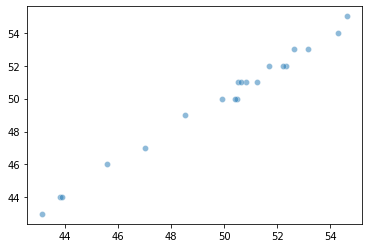

In [957]:
n_obs = 20
x_true = rg.beta(.5*100, .5*100, n_obs)*100
x_obs = round_to_one(x_true)

sns.scatterplot(x_true, x_obs, alpha=.5)

In [950]:
from jax.scipy.special import logsumexp

def numeric_beta_cdf(a, b, x, approx_steps=10000):
    base = jnp.zeros(x.shape) + jnp.exp(-50)
#     eps = np.finfo(np.float32).eps
    x = jnp.exp(jnp.clip(jnp.log(x), a_max=-jnp.exp(-17), a_min = -50))
    
    x_region = jnp.linspace( base, x, approx_steps)
    return jnp.sum(jnp.exp(dist.Beta(a, b).log_prob(x_region) + (jnp.log(x) - jnp.log(x_region.shape[0]))), axis=-2)
#     return jnp.exp(logsumexp(dist.Beta(a, b).log_prob(x_region), axis=-2) + (jnp.log(x) - jnp.log(x_region.shape[0])))

%timeit numeric_beta_cdf(1,1, jnp.array([.5]), 100)
%timeit numeric_beta_cdf(1,1, jnp.array([.5]), 10000)


A = 1
B = 1
print(numeric_beta_cdf(A, B, jnp.array([.5, .1, 1, 0, .999])))
print(dist.Beta(A, B).cdf(jnp.array([.5, .1, 1, 0, .999])))
# dist.Beta(A,B).log_prob(1.)

7.94 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.75 ms ± 94.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[5.00000000e-01 1.00000000e-01 9.99999959e-01 1.92874985e-22
 9.99000000e-01]
[0.5   0.1   1.    0.    0.999]


In [951]:
def normalize_probs(probs):
    log_probs = jnp.log(probs)
    return jnp.exp( log_probs - logsumexp(log_probs))

def spread_vec(x, step_size):
    base_steps = x.shape[0]
    x_tall = x.reshape(-1,1) # reshape
    eps = np.finfo(np.float32).eps
    pad = jnp.zeros([x.shape[0], step_size-1]) + eps # make (almost) zeros
    probs = jnp.concatenate((x_tall, pad), axis=-1).flatten() # concatenate and flatten
    probs = probs[:base_steps*step_size - (step_size-1)]    # index
    
    return normalize_probs(probs) # normalize probabilities

def cat_probs_beta(a, b, step_size, max_size=101):

    lower_pts, upper_pts = make_cuts(0,101,step_size)
    probs = numeric_beta_cdf(a, b, upper_pts/100.) - numeric_beta_cdf(a, b, lower_pts/100.) # make sure it's non-zero

    return probs #normalize_probs(probs)


def rounding_model_beta(x_obs, step_size=5):

    mu = numpyro.sample("mu", dist.Beta(1,1))
    k = numpyro.sample("k", dist.HalfCauchy(20))
    
    with numpyro.plate("data", x_obs.shape[0]):

#         x_true_cp = spread_vec(cat_probs_beta(mu*k, (1-mu)*k, step_size), step_size)
        x_true_cp = cat_probs_beta(mu*k, (1-mu)*k, step_size)
        numpyro.sample("x", dist.Categorical(x_true_cp), obs=x_obs/step_size)
#         numpyro.sample("x", dist.Beta(mu*k, (1-mu)*k), obs = x_obs/100.) # this works fine
        
# jnp.exp(logsumexp(jnp.log(cat_probs_beta(3,4,6))))
# sns.lineplot(x=jnp.arange(0,101), y=spread_vec(cat_probs_beta(.25*20,.75*20, 5), 5))

In [958]:
from numpyro.infer.initialization import init_to_value

mcmc_test = MCMC(NUTS(rounding_model_beta, 
                      target_accept_prob=.80,
#                       init_strategy = init_to_value(values = {"mu":0., "k":1.})
                     ), 
                 1000, 1000, num_chains=1)
mcmc_test.run(random.PRNGKey(0), x_obs, 1)   

sample: 100%|██████████| 2000/2000 [09:40<00:00,  3.44it/s, 15 steps of size 1.06e-01. acc. prob=0.93]


In [961]:
mcmc_test.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k     17.40     25.43      9.28      0.11     37.86    204.54      1.00
        mu      0.01      0.02      0.00      0.00      0.02    113.40      1.02

Number of divergences: 0


3/30/21, 3:49 PM: just ran this and got correct mu and biased k, so it is not quite right but it is a lot closer than it ever has been. Also had divergences and effectively no samples so not sure how close this really is but it's definitely a bit less wrong.

I suspect I am running into numerical precision problems which is the kind of thing that happens when you try to implement a probability distribution yourself. Unfortunately it's not something I know a ton about so I don't know how I can fix this myself. It could also be that numerically integrating to get the CDF was just a kooky idea the whole time.

(101,)

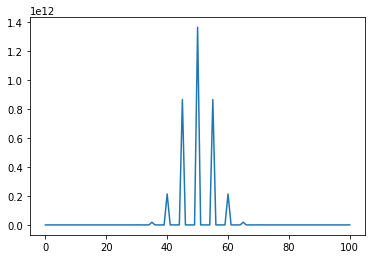

In [366]:

def spread_vec(x, step_size):
    base_steps = x.shape[0]
    x_split = jnp.split(x, base_steps)
    pad = jnp.zeros(step_size-1) + jnp.exp(-30)
    probs = jnp.stack([jnp.concatenate((i,pad)) for i in x_split]).flatten()
    
    return probs[:-(step_size-1)]/jnp.sum(probs[:(step_size-1)]) # normalize probabilities

# x = spread_vec(cat_probs_beta(.5*100, .5*100, 5), 5)
x = spread_vec(cat_probs_logitnormal(0, .2, 5), 5)

sns.lineplot(x = jnp.arange(0,101), y = x)
x.shape


In [960]:
def numeric_norm_cdf(mu, sigma, lower, upper, approx_steps=1000):
    
    x_region = jnp.linspace( lower, upper, approx_steps)
    return jnp.sum(jnp.exp(dist.Normal(mu, sigma).log_prob(x_region))*(x/x_region.shape[0]), axis=-2)


In [115]:
low

DeviceArray([ 0.,  5., 15., 25., 35., 45., 55., 65., 75., 85., 95.], dtype=float32)

In [116]:
up
# len([0-5, 5-15, 15-25, 25-35, 35-45, 45-55, 55-65, 65-75, 75-85, 85-95, 95-100])

DeviceArray([  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.,
             100.], dtype=float32)